<a href="https://colab.research.google.com/github/PerezTorresJhoyceR/IA_Sis420/blob/main/laboratorio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import optimize

Esto carga el archivo CSV con los datos del bosque.


In [27]:
# Cargar el dataset Forest Cover Type desde Drive
df = pd.read_csv('/content/drive/MyDrive/IA/covtype.csv')
print (df.shape)

print("Variables utilizadas para predecir:")
print(df.drop('Cover_Type', axis=1).columns.tolist())


(581012, 55)
Variables utilizadas para predecir:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


['Elevación', 'Aspecto', 'Pendiente', 'Distancia_Horizontal_A_Hidrología', 'Distancia_Vertical_A_Hidrología', 'Distancia_Horizontal_A_Vías', 'Sombras_de_colinas_9am', 'Sombras_de_colinas_Mediodía', 'Sombras_de_colinas_3pm', 'Distancia_Horizontal_A_Puntos_de_Fuego', 'Área_Silvestre1', 'Área_Silvestre2', 'Área_Silvestre3', 'Área_Silvestre4', 'Tipo_de_Suelo1'

en este apartado se toma en cuenta la cantidad de ejemplos para que en cada ejmplo haya una misma cantidad, y asi todas las clases pueden aprender de la misma manera que todas las demas.


/tmp/ipython-input-2921363237.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_samples, random_state=42))


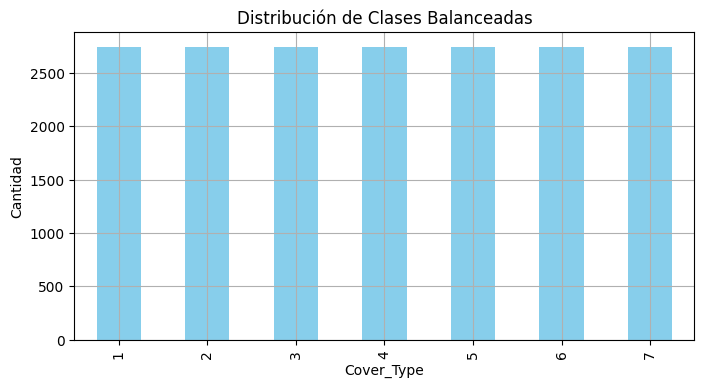

In [28]:
# Balanceo del dataset: tomar el mínimo disponible por clase
min_samples = df['Cover_Type'].value_counts().min()
df_balanced = (
    df.groupby('Cover_Type', group_keys=False) # Keep 'Cover_Type' as a column after groupby
      .apply(lambda x: x.sample(n=min_samples, random_state=42))
      .reset_index(drop=True)
)

# Verificación visual de clases balanceadas
plt.figure(figsize=(8,4))
df_balanced['Cover_Type'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases Balanceadas')
plt.xlabel('Cover_Type')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()

aqui se separa lo que realmente se desea predecir, el tipo de bosque, se lo separa de lo que realmente se usara para hacer la prediccion, los datos geograficos.

In [29]:
# Separar características y etiquetas
X = df_balanced.drop('Cover_Type', axis=1).values
y = df_balanced['Cover_Type'].values

aqui se va a separa los datos, en un 80% de entrenamiento y de 20 % para la prueba

In [30]:
# División 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Se van a normalizar los datos, todos a una misma escala

In [31]:
# Normalización de características (evita división por cero)
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    sigma[sigma == 0] = 1  # Evita división por cero
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X_train_norm, mu, sigma = featureNormalize(X_train)
X_test_norm = (X_test - mu) / sigma

la Sigmoide esta en este apartado para ver las posibilidade, y luego se ve la funcion de costo para ver como esta yendo el modelo si bien o mal

In [32]:
# Función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Función de costo regularizada
def lrCostFunction(theta, X, y, lambda_):
    m = y.size
    h = sigmoid(X.dot(theta))
    J = (-1/m) * (y.dot(np.log(h)) + (1 - y).dot(np.log(1 - h))) + (lambda_/(2*m)) * np.sum(np.square(theta[1:]))
    grad = (1/m) * X.T.dot(h - y)
    grad[1:] += (lambda_/m) * theta[1:]
    return J, grad

aqui tenemos el entrenamiento con ones-vs-all, se entrenara el modelo, haciendo 200 iteraciones para cada una de las clases

In [33]:
# Entrenamiento One-vs-All con registro de costos
def OneVsAllOM(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    all_costs = []

    for c in np.arange(1, num_labels + 1):
        initial_theta = np.zeros(n + 1)
        cost_history = []

        def callback(theta):
            J, _ = lrCostFunction(theta, X, (y == c).astype(int), lambda_)
            cost_history.append(J)

        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c).astype(int), lambda_),
                                jac=True,
                                method='CG',
                                options={'maxiter': 200},
                                callback=callback)
        all_theta[c - 1] = res.x
        all_costs.append(cost_history)
    return all_theta, all_costs

ahora se hace la prediccion para poder ver a que clase pertenece cada bosque

In [34]:
# Predicción multiclase
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis=1) + 1
    return p

ahora se graficara cada uno de los resultados

 Precisión en prueba: 65.60%


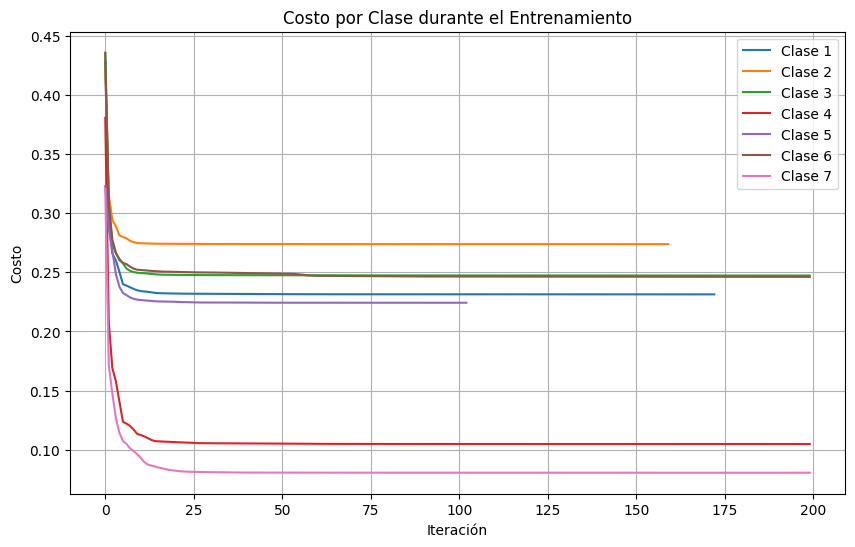

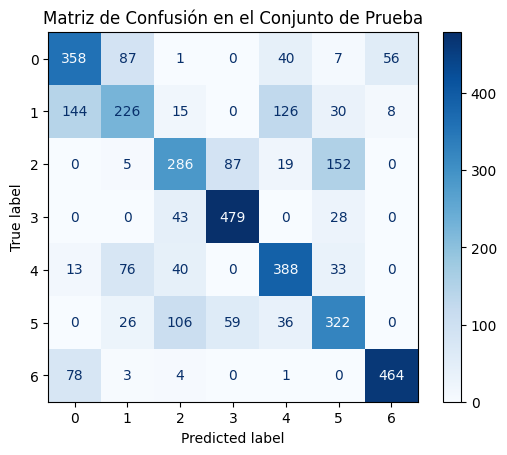

In [36]:
# Gráfico de costo por clase
def plot_costs(costs, title='Costo por Clase durante el Entrenamiento'):
    plt.figure(figsize=(10, 6))
    for i, cost_list in enumerate(costs):
        plt.plot(cost_list, label=f'Clase {i+1}')
    plt.xlabel('Iteración')
    plt.ylabel('Costo')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Matriz de confusión
def plot_confusion(y_true, y_pred, title='Matriz de Confusión en el Conjunto de Prueba'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

# Parámetros del modelo
num_labels = 7
lambda_ = 0.1

#  Entrenamiento del modelo
all_theta, all_costs = OneVsAllOM(X_train_norm, y_train, num_labels, lambda_)

# Evaluación del modelo
pred_train = predictOneVsAll(all_theta, X_train_norm)
pred_test = predictOneVsAll(all_theta, X_test_norm)

print(' Precisión en prueba: {:.2f}%'.format(np.mean(pred_test == y_test) * 100))

#  Visualización de resultados
plot_costs(all_costs, title='Costo por Clase durante el Entrenamiento')
plot_confusion(y_test, pred_test, title='Matriz de Confusión en el Conjunto de Prueba')
